# ITCS 3162 Final Group Project

In [1]:
#Import necessary tools
#DF Imports
import pandas as pd
import numpy as np

#Viz imports
import matplotlib.pyplot as plt
import seaborn as sns


#Modeling imports
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from scipy import stats
from sklearn.svm import LinearSVC
import re
import random
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Eval imports
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score


print("Setup Complete!")

Setup Complete!


## Import data

In [2]:
#Import training data for exploration

df = pd.read_csv('train.csv')

In [3]:
#Look at the shape
df.shape

(891, 12)

In [4]:
#Take a look at the head to get a feel for the data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Some of the column names are a little bit confusing so let's see if we can get a little bit more clarity
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Pre-processing

In [6]:
#Let's start by looking for NA values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are some pretty substantial amounts of NA data. we'll need to look for any underlying causes and either impute missing data or drop observations. Specifically, missing cabin data and home destination could have meaningful impacts on the ability to predict survival or death.

In [7]:
#Check for duplicated observations 
df.duplicated().value_counts()

False    891
dtype: int64

In [8]:
#Check data types for each feature
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* Note to consider whether any of the quantitative data types work better as categorical binned features and convert in alt df if useful 
* Note to revisit looking for outliers after checking for them during EDA

## Exploratory Data Analysis and Visualization

### Survival

In [38]:
#Let's start off by trying to understand our target a little bit better
df.Survived.describe()

count     891
unique      2
top        no
freq      549
Name: Survived, dtype: object

It looks like the target variable is a binary 0/1. Documentation notes that 0 indicates death and 1 indicates survival. We should probably consider changing this to a standardized 'Yes' or 'No' String to make it a little bit clearer for users reading our code.

In [19]:
#Create a function to convert 0/1 survival indicators to yes no for ease of comprehension
def survived_to_string(row):
    if (row['Survived'] == 0):
        return 'no'
    if (row['Survived'] == 1):
        return 'yes'

In [20]:
#Apply the function that we've created to create a new column
df['Survived_txt'] = df['Survived'] = df.apply(lambda row: survived_to_string(row), axis = 1)

In [21]:
#Let's double check that our column appears with the expected results
df['Survived_txt'].value_counts()

no     549
yes    342
Name: Survived_txt, dtype: int64

In [22]:
df['Survived'].value_counts()

no     549
yes    342
Name: Survived, dtype: int64

Let's start by  looking at the raw distribution of survival outcomes. We'll circle back and look at survival in combination with different features down the road but we'll start with a simple viz.

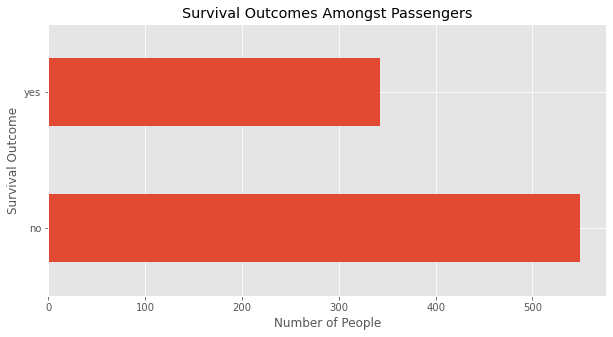

In [29]:
#Create a bar graph visualization of survival
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

df.groupby('Survived_txt').size().plot(kind = 'barh').set(title = 'Survival Outcomes Amongst Passengers', 
                                                          xlabel = 'Number of People', ylabel = 'Survival Outcome')
plt.show()
#plt.savefig('surival.png', bbox_inches = 'tight')

### Passenger Class

In [39]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

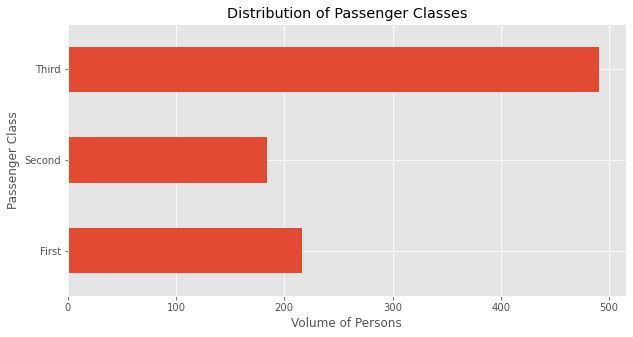

In [41]:
#Now let's look at the distribution of passenger classes
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

df.groupby('Pclass').size().plot(kind = 'barh').set(title = 'Distribution of Passenger Classes', 
                                                          xlabel = 'Volume of Persons', ylabel = 'Passenger Class',
                                                   yticklabels = 
                                                    ['First', 'Second', 'Third'])
plt.show()
#plt.savefig('surival.png', bbox_inches = 'tight')